In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import mplhep

import iminuit
from iminuit import Minuit
from iminuit.cost import LeastSquares
import glob

import utils
utils.make_style()

from jacobi import propagate

## Toy DATA model

Genero una distribuzione di punti necessaria ad un eventuale test di programma

```python
def hundred2rad(hundred):
    return hundred * np.pi / 50
    
def rad2hundred(rad):
    return rad * 50 / np.pi

angle = np.linspace(10, 100, 10)
for a in angle:
    filename = f'data/{a}.2000.test.txt' 
    a_rad = hundred2rad(a)
    means = np.ones(10) * np.cos(a_rad)**2 + np.random.rand(10)*0.1
    np.savetxt(filename,means)
```
        
        

# Polarization of light


In [35]:
def hundred2rad(hundred):
    return hundred * np.pi / 50
def rad2hundred(rad):
    return rad * 50 / np.pi

class DataPolarization:
    
    def __init__(self,filenames_glob: str = None, skiprows = 23):
        
        self.mean = np.zeros_like(filenames_glob, dtype=np.float64)
        self.std = np.zeros_like(filenames_glob, dtype=np.float64)
        self.angle = np.zeros_like(filenames_glob, dtype=np.float64)
        
        self.ID = filenames_glob[0].split('/')[1].split('_')[-1]
        self.maximum = 0
        self.max_std = 0
        
        for i, filename in enumerate(filenames_glob):
            data = np.loadtxt(filename, skiprows=skiprows, dtype=np.float64)
            self.mean[i] = data.mean()
            self.std[i] = data.std()
            
            hundred = np.float64(filename.split('.')[0].split('/')[-1])
            self.angle[i] = hundred2rad(hundred) ## self.angle will always be in radians ;) 
    
    def plot(self, rad: bool = True, angle_bias: np.float64 = 0, costh_bias: np.float64 = 0):
        
        angle = self.angle
        ylabel = r'Light intensity ($I/I_0=\cos^2\theta$)'
        xlabel = r'Angle/rad'
        if not rad:
            angle = rad2hundred(self.angle) ## Angle is in HUNDREDS!
            xlabel = r'Angle/grad/4'
        
        plt.errorbar(angle-angle_bias, self.mean-costh_bias, yerr=self.std, 
                     ecolor='k', fmt='k.', mfc='w', label=f'Data ({self.ID})', markersize=8)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
    
    def model(x, p):
        norm, phase, offset = p
        return offset + norm * np.cos(x + phase)**2
    
    def fit(self, verbose = False, norm = 5, angle_bias = -2.82, costh_bias = 0):
        
        fcn = LeastSquares(self.angle, self.mean, self.std, model)
        minimizer = Minuit(fcn, (norm, angle_bias, costh_bias))
        minimizer.migrad()
        if verbose: print(minimizer)
        
        
        angles = np.linspace(self.angle.min(), self.angle.max(),100)
        y, ycov = propagate(
            lambda p: model(angles, p), minimizer.values, minimizer.covariance)
        yerr_prop = np.diag(ycov)**0.5
        
        return minimizer.values, minimizer.errors, angles, y, yerr_prop
    

## Actual measurements

Prima presa dati, considerando una raccolta varia su 10 punti come simulato.

In [36]:
model = lambda x, p: p[0] * (p[2] + np.cos(x + p[1])**2)

def plot_fit(fit_values, data: DataPolarization, plot_error: bool = True):
    
    values, _, x, y, yprop = fit_values
    plt.plot(x, y, label=f'Fit model ({data.ID})')
    if plot_error:
        plt.fill_between(x, y+yprop, y-yprop, 
                         facecolor='gray', alpha=0.75,label='1$\sigma$ error')
        plt.fill_between(x, y+2*yprop, y-2*yprop, 
                         facecolor='gray', alpha=0.25,label='2$\sigma$ error')

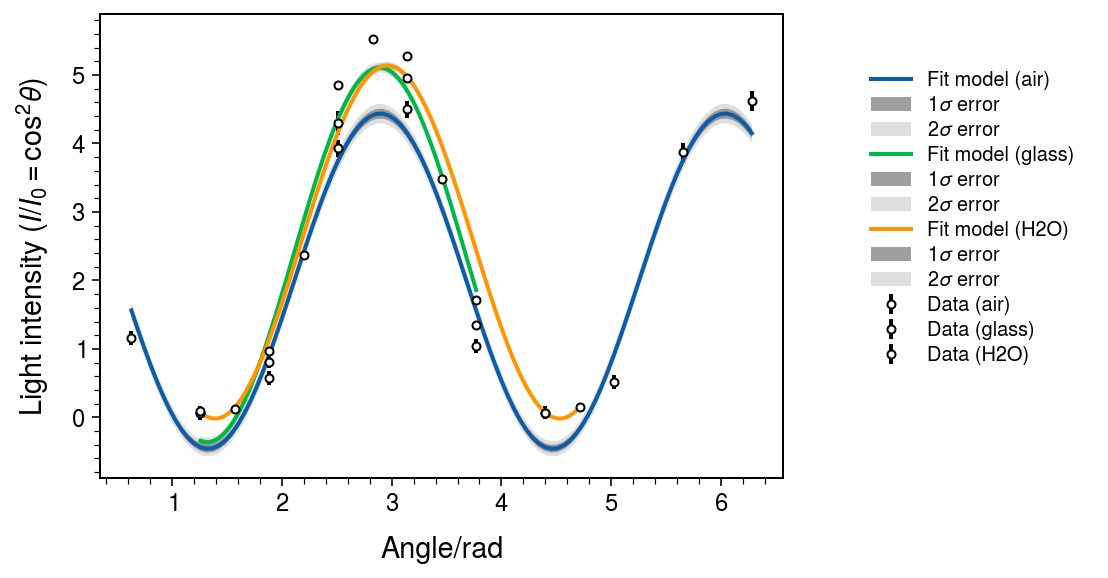

In [37]:
data_0 = glob.glob('data/data_air/**')


data_0 = DataPolarization(data_0)

data_0.std = data_0.std + 0.1## Error scaling!

data_0.plot()
fitd_0 = data_0.fit()
plot_fit(fitd_0, data_0)

data_glass = DataPolarization(glob.glob('data/data_glass/**'))
data_glass.angle -= np.pi

data_glass.std = data_glass.std + 0.05 ## Error scaling!

data_glass.plot()
fitd_glass = data_glass.fit()
plot_fit(fitd_glass, data_glass)

data_H2O = glob.glob('data/data_H2O/**')

data_H2O = DataPolarization(data_H2O)
data_H2O.angle -= np.pi
data_H2O.plot()
fitd_H2O = data_H2O.fit()
plot_fit(fitd_H2O, data_H2O)

plt.legend(loc=(1.1,0.2))

## Sugar concentration

Consideriamo una soluzione di zucchero in $\mathrm{H_2O}$ osservando che andando a modificare la concentrazione di zucchero (passiamo da 1, 1/2, 1/4, ...) l'angolo di polarizzazione cambia e tende a zero.

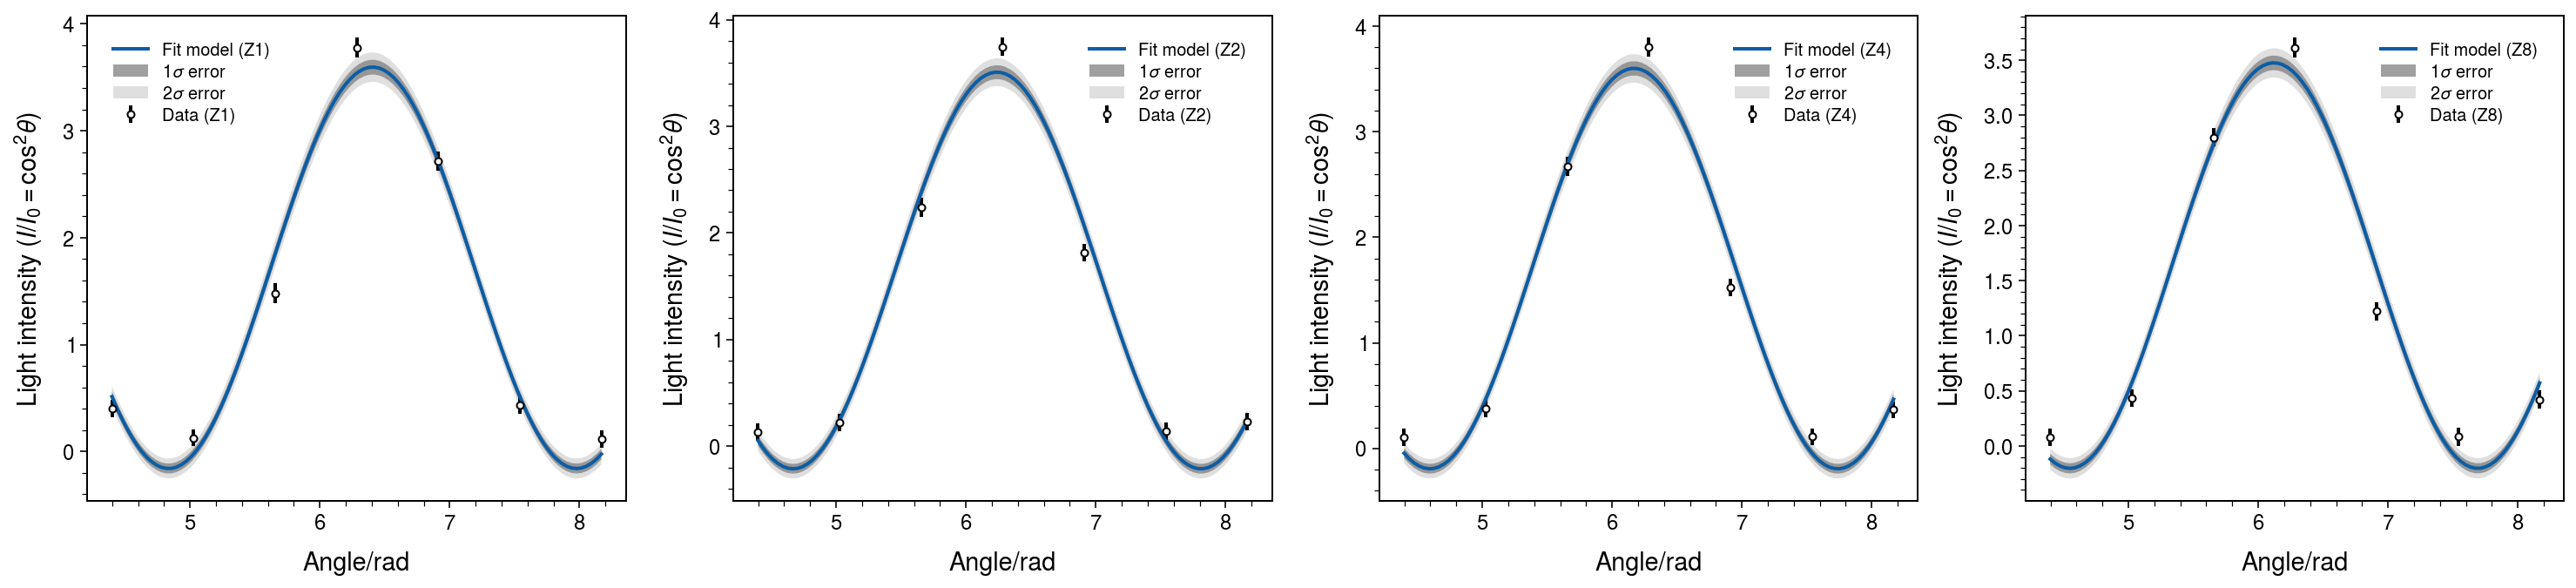

In [40]:
data_Z1 = DataPolarization(glob.glob('data/data_Z1/**')); data_Z1.std += 0.08 ## Error scaling!
data_Z2 = DataPolarization(glob.glob('data/data_Z2/**')); data_Z2.std += 0.08 ## Error scaling!
data_Z4 = DataPolarization(glob.glob('data/data_Z4/**')); data_Z4.std += 0.08 ## Error scaling!
data_Z8 = DataPolarization(glob.glob('data/data_Z8/**')); data_Z8.std += 0.08 ## Error scaling!


fitData_Z1 = data_Z1.fit()
fitData_Z2 = data_Z2.fit()
fitData_Z4 = data_Z4.fit()
fitData_Z8 = data_Z8.fit()


fig = plt.figure(figsize=(25, 4.8))
gs = fig.add_gridspec(1, 4)
fig.add_subplot(gs[0])
data_Z1.plot()
plot_fit(data_Z1.fit(), data_Z1)
plt.legend()

fig.add_subplot(gs[1])
data_Z2.plot()
plot_fit(data_Z2.fit(), data_Z2)
plt.legend()

fig.add_subplot(gs[2])
data_Z4.plot()
plot_fit(data_Z4.fit(), data_Z4)
plt.legend()

fig.add_subplot(gs[3])
data_Z8.plot(True)
plot_fit(data_Z8.fit(), data_Z8)
plt.legend()


Definisco una funzione che possa trovare il valore dell'angolo per cui ho il massimo dell'intensità, che dovrebbe corrispondere a $\theta = 0$.

In [41]:
import scipy.optimize

def get_maximum(fit_data):
    values, errors, _, _, _ = fit_data
    
    bounds = [-np.pi/2, np.pi/2]
    
    maximum = scipy.optimize.minimize_scalar(lambda x: - DataPolarization.model(x, values), bounds=bounds, method='bounded').x
    error_squared_pos = 0
    error_squared_neg = 0
    
    def array_j(j, n): 
        a = np.zeros(n)
        a[j] += 1
        return a
    
    for j in range(3):
        corrected_values_positive = [values[i] + (array_j(j, 3)*errors)[i] for i in range(3)]
        corrected_values_negative = [values[i] - (array_j(j, 3)*errors)[i] for i in range(3)]
        error_squared_pos += np.abs(
            scipy.optimize.minimize_scalar(lambda x: - DataPolarization.model(x, corrected_values_positive), bounds=bounds, method='bounded').x - maximum
        )**2
        error_squared_neg += np.abs(
            scipy.optimize.minimize_scalar(lambda x: - DataPolarization.model(x, corrected_values_negative), bounds=bounds, method='bounded').x - maximum
        )**2
    
    return maximum, error_squared_neg, error_squared_pos

Definiscoa anche la funzione che trova il minimo più vicino, per poter confrontare i plot di massimo e minimo

In [42]:
def get_minimum(fit_data):
    values, errors, _, _, _ = fit_data
    
    bounds = [0, np.pi]
    
    minimum = scipy.optimize.minimize_scalar(lambda x: DataPolarization.model(x, values), bounds=bounds, method='bounded').x
    error_squared_pos = 0
    error_squared_neg = 0
    
    def array_j(j, n): 
        a = np.zeros(n)
        a[j] += 1
        return a
    
    for j in range(3):
        corrected_values_positive = [values[i] + (array_j(j, 3)*errors)[i] for i in range(3)]
        corrected_values_negative = [values[i] - (array_j(j, 3)*errors)[i] for i in range(3)]
        error_squared_pos += np.abs(
            scipy.optimize.minimize_scalar(lambda x: DataPolarization.model(x, corrected_values_positive), bounds=bounds, method='bounded').x - minimum
        )**2
        error_squared_neg += np.abs(
            scipy.optimize.minimize_scalar(lambda x: DataPolarization.model(x, corrected_values_negative), bounds=bounds, method='bounded').x - minimum
        )**2
    
    return minimum, error_squared_neg, error_squared_pos

Cerco il valore del massimo per i casi *semplici*, ovvero H2O e solo vetro, per trovare il fattore di correzione per il caso successivo. 

In [43]:
x0_0 = get_maximum(fitd_0)[0]
x0_glass = get_maximum(fitd_glass)[0]
x0_H2O = get_maximum(fitd_H2O)[0]

center = np.array([x0_0, x0_glass, x0_H2O]).mean()

Cerco il valore del massimo per tutte le distribuzioni con concentrazioni differenti, e considero poi di togliere il valore centrale. 

In [44]:
fit_datasets = [
    fitData_Z1,
    fitData_Z2,
    fitData_Z4,
    fitData_Z8
]

concentration = np.array([1, 0.5, 0.25, 0.125])
maxs = np.array([get_maximum(fitd)[0] for fitd in fit_datasets])
maxs -= center

Cerco anche l'errore propagando sui risultati del fit

In [45]:
max_error_neg = np.array([get_maximum(fitd)[1] for fitd in fit_datasets])
max_error_pos = np.array([get_maximum(fitd)[2] for fitd in fit_datasets])

max_errors_asy = np.array(list(zip(max_error_neg, max_error_pos))).T.mean(0)

Procedo con gli stessi calcoli anche per il minimo.

In [46]:
mins = np.array([get_minimum(fitd)[0] for fitd in fit_datasets])
mins -= center

min_error_neg = np.array([get_minimum(fitd)[1] for fitd in fit_datasets])
min_error_pos = np.array([get_minimum(fitd)[2] for fitd in fit_datasets])

min_errors_asy = np.array(list(zip(min_error_neg, min_error_pos))).T.mean(0)

Definisco un modello lineare e cerco la relazione tra concentrazione e angolo di rotazione del piano di polarizzazione.

In [47]:
model = lambda x, p: p[0] + x*p[1]

fcn_max = LeastSquares(concentration, maxs, max_errors_asy, model)
mmax = Minuit(fcn_max, (0, 0.4))
mmax.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2083 (chi2/ndof = 1041.6)  │              Nfcn = 38               │
│ EDM = 1.57e-20 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │ 24.34e-3  │  0.14e-3  │            │            │         │         │       │
│ 1 │ x1   │ 322.81e-3 │  0.24e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────┐
│    │        x0        x1 │
├────┼─────────────────────┤
│ x0 │  1.81e-08 -2.62e-08 │
│ x1 │ -2.62e-08  5.74e-08 │
└────┴─────────────────────┘

Trovo anche il valore a $1\sigma$ e $2\sigma$ propagando gli errori sul fit

Per il minimo anche posso otttenere

In [48]:
fcn_min = LeastSquares(concentration, mins, min_errors_asy, model)
mmin = Minuit(fcn_min, (0, 0.4))
mmin.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2083 (chi2/ndof = 1041.6)  │              Nfcn = 40               │
│ EDM = 4.18e-16 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  1.59513  │  0.00014  │            │            │         │         │       │
│ 1 │ x1   │ 322.81e-3 │  0.24e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────┐
│    │        x0        x1 │
├────┼─────────────────────┤
│ x0 │  1.81e-08 -2.62e-08 │
│ x1 │ -2.62e-08  5.74e-08 │
└────┴─────────────────────┘

Faccio il plot angolo/concentrazione %

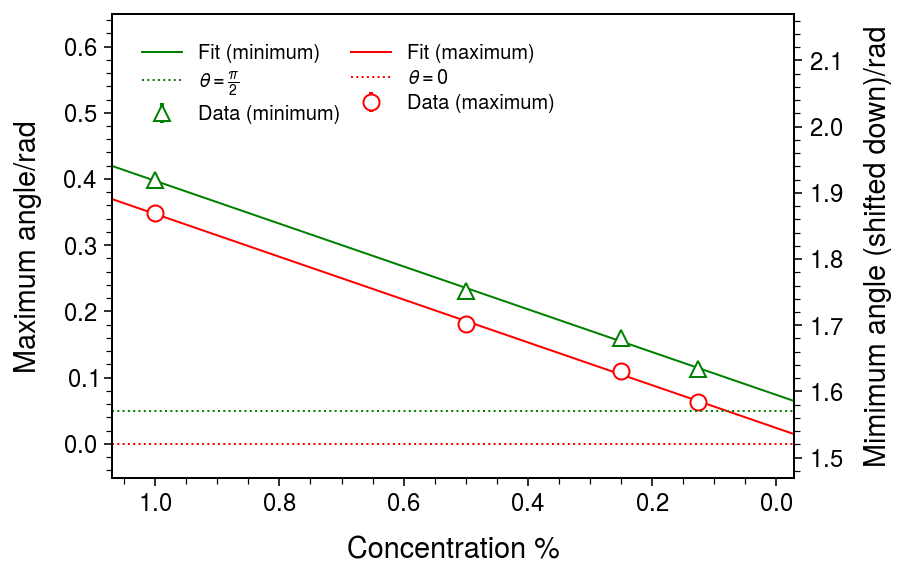

In [58]:
fig, ax = plt.subplots()

xmin, xmax = (1.07,-0.03)
ymin, ymax = (1.47, 2.17)
conc_overshoot = np.linspace(xmin, xmax, 100)

ax.errorbar(concentration, maxs, yerr=max_errors_asy, fmt='ro', mfc='w', label='Data (maximum)')
p1 = ax.plot(conc_overshoot, model(conc_overshoot, mmax.values), 'r', lw=1, label='Fit (maximum)')
ax.set_xlim(0, 1.1)
ax.set_xlabel('Concentration %')
ax.set_ylabel('Maximum angle/rad')
offset = np.pi/2 - 0.05

ax.set_ylim(ymin-offset, ymax-offset)
ax.axhline(0, ls=':', c='r', lw=1, label=r'$\theta=0}$')

ax.legend(loc='upper center')

ax2 = ax.twinx()

ax2.errorbar(concentration, mins, yerr=min_errors_asy, fmt='g^', mfc='w', label='Data (minimum)')
ax2.plot(conc_overshoot, model(conc_overshoot, mmin.values), 'g', lw=1, label='Fit (minimum)')
ax2.set_ylabel('Mimimum angle (shifted down)/rad')

ax2.set_ylim(ymin, ymax)
ax2.set_xlim(xmin, xmax)
ax2.axhline(np.pi/2, ls=':', c='g', lw=1, label=r'$\theta=\frac{\pi}{2}$')

ax2.legend(loc='upper left')

Considerando allora una legge come $\theta = C_\% \cdot \alpha$, avremo due valori conseguenti di $\alpha$. Ma vediamo che in realtà sono corrispondenti, entro il loro errore. Ottteniamo infatti

In [59]:
from uncertainties import ufloat

print(f'α(max) = {ufloat(mmax.values[1], mmax.errors[1]):uS}')
print(f'α(min) = {ufloat(mmin.values[1], mmin.errors[1]):uS}')

α(max) = 0.32281(24)
α(min) = 0.32281(24)


### Appunto (consiglio di Andre Parodi)
Il valore del massimo in realtà si può anche trovare considerando che $\cos^2\theta$ è teoricamente centrato sullo zero, mentre dai nostri dati risulta non centrato sullo zero. Quindi noto il valore della fase (che possiamo ottenere dal fit), possiamo trovare facilmente il valore del massimo più vicino

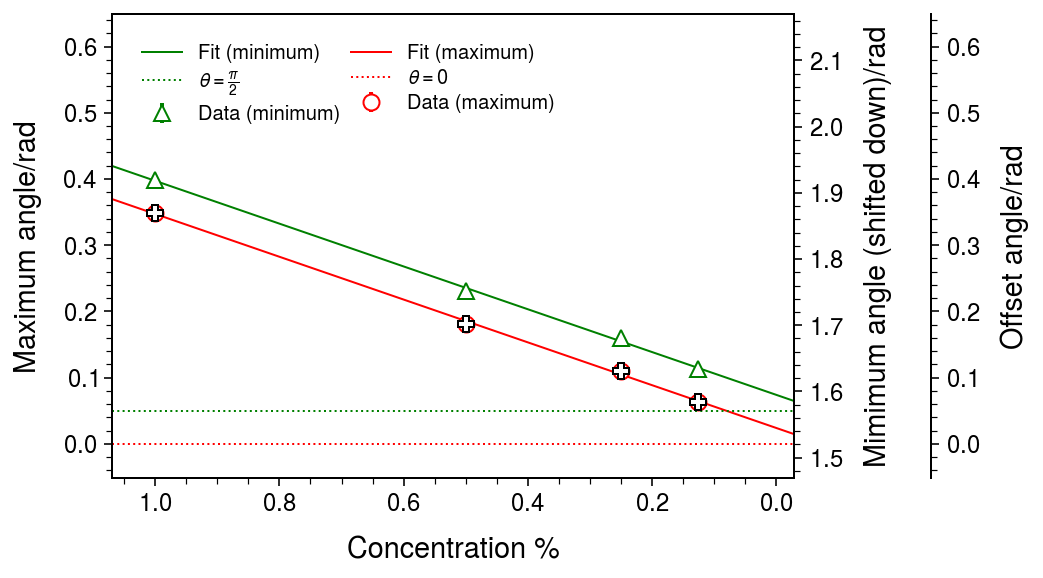

In [60]:
ax3 = ax.twinx()
ax3.set_ylabel('Offset angle/rad')
ax3.spines['right'].set_position(('axes',1.2))

max_3 = np.array([-fitd[0][1] for fitd in fit_datasets]) - center - np.pi
max_3_std = np.array([-fitd[1][1] for fitd in fit_datasets])

ax3.errorbar(concentration, max_3, yerr=max_3_std, fmt='kP', mfc='w', label=r'Data offset ($-\pi$)')

ax3.set_ylim(ymin-offset, ymax-offset)

fig

In [61]:
fcn_off = LeastSquares(concentration, max_3, max_3_std, model)
moff = Minuit(fcn_off, (0, 0.4))
moff.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.3222 (chi2/ndof = 0.2)   │              Nfcn = 34               │
│ EDM = 2.08e-21 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.024   │   0.011   │            │            │         │         │       │
│ 1 │ x1   │   0.323   │   0.019   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────┐
│    │        x0        x1 │
├────┼─────────────────────┤
│ x0 │  0.000116 -0.000165 │
│ x1 │ -0.000165  0.000357 │
└────┴─────────────────────┘

Abbiamo ottenuto un valore 

In [62]:
print(f'α(min) = {ufloat(moff.values[1], moff.errors[1]):uS}')

α(min) = 0.323(19)


In [63]:
y, ycov = propagate(lambda p: model(conc_overshoot, p), moff.values, moff.covariance)
yerr_prop = np.diag(ycov)**0.5

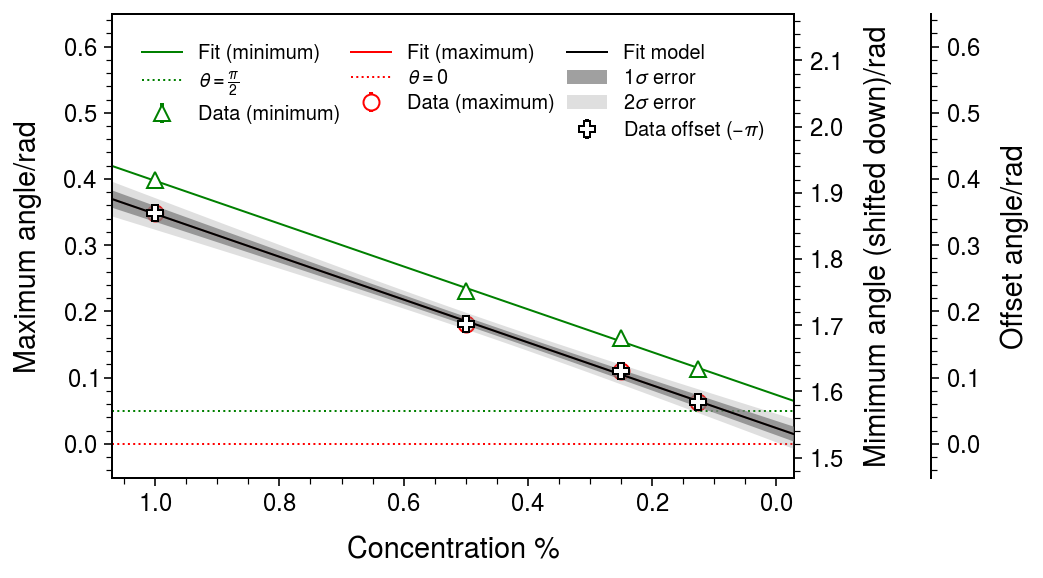

In [64]:
ax3.plot(conc_overshoot, model(conc_overshoot, moff.values), color='k', lw=1, label='Fit model')
ax3.fill_between(conc_overshoot, y+yerr_prop, y-yerr_prop, facecolor='gray', alpha=0.75,label='1$\sigma$ error')
ax3.fill_between(conc_overshoot, y+2*yerr_prop, y-2*yerr_prop, facecolor='gray', alpha=0.25,label='2$\sigma$ error')
ax3.legend(loc='upper right')
fig

In [65]:
fig.savefig('plot.pdf', bbox_inches='tight')